### Generate simulated dataset and decompose ST

In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import importlib as imp
import spotiphy
import anndata as ad
import umap
imp.reload(spotiphy)

<module 'spotiphy' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\__init__.py'>

In [2]:
%%time
adata_sc_files = ["F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad",
                  "F:/Ziqian Zheng/Spotiphy_data/SCRNA/sum_43plus_anno.h5ad",]
adata_sc = sc.read_h5ad(adata_sc_files[1])
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
# adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/Simulated_ST_221_1.h5ad")
adata_st.var_names_make_unique()
results_folder = 'results/221_43plus/'
key_type = 'majortype'
type_list = sorted(list(adata_sc.obs[key_type].unique()))
cell_proportion = np.load(results_folder+'proportion.npy')

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: total: 1min 36s
Wall time: 1min 36s


In [3]:
img = sq.im.ImageContainer('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
Segmentation = spotiphy.segmentation.Segmentation(img['image'][:, :, 0], adata_st.obsm['spatial'], out_dir=results_folder)
Segmentation.segment_nucleus(save=False)
adata_st.obs[Segmentation.n_cell_df.columns] = Segmentation.n_cell_df.values
adata_st.obs = adata_st.obs.drop('Nucleus centers', axis=1)

Suppress the output of tensorflow prediction for tensorflow version 2.12.0>=2.9.0.


Image.py (3176): Image size (99010000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


100%|██████████| 64/64 [01:18<00:00,  1.22s/it]


In [4]:
adata_st.obs.head()

in_tissue  array_row  array_col cell_count
AAACAAGTATCTCCCA-1          1         50        102          4
AAACACCAATAACTGC-1          1         59         19          5
AAACAGAGCGACTCCT-1          1         14         94          4
AAACAGCTTTCAGAAG-1          1         43          9          7
AAACAGGGTCTATATT-1          1         47         13          5

In [5]:
%%time
adata_st_new = spotiphy.deconvolution.simulation(adata_st, adata_sc, key_type, cell_proportion,
                                                 n_cell='cell_count', save=True, out_dir=results_folder)

_index.py (137): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
deconvolution.py (180): Trying to modify attribute `._uns` of view, initializing view as actual.


CPU times: total: 4min 22s
Wall time: 4min 22s


In [6]:
adata_st = adata_st_new.copy()

In [7]:
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st)
marker_gene = spotiphy.marker_selection(adata_sc, key_type=key_type, return_dict=False, n_select=40)
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)

In [9]:
X = np.array(adata_st.X)
pyro_params = spotiphy.deconvolution.deconvolute(X, sc_ref, n_epoch=10000)
sigma = pyro_params['sigma'].cpu().detach().numpy()
mean_exp = np.array([np.mean(np.sum(adata_sc.X[adata_sc.obs[key_type]==type_list[i]], axis=1)) for i in range(len(type_list))])
cell_proportion = sigma/mean_exp
cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]

100%|██████████| 10000/10000 [07:49<00:00, 21.30it/s]


In [13]:
cell_count_truth = adata_st.obsm['ground_truth']
proportion_truth = cell_count_truth/np.sum(cell_count_truth, axis=1, keepdims=True)
print(np.mean(np.abs(proportion_truth-cell_proportion)))

0.05746632435670289


In [10]:
adata_sc = sc.read_h5ad(adata_sc_files[1])

In [11]:
%%time
adata_st_decomposed = spotiphy.deconvolution.decomposition(adata_st_new, adata_sc, key_type, cell_proportion, save=True,
                               out_dir=results_folder, threshold=0.1, spot_location=adata_st.obsm['spatial'],
                               filename='ST_decomposition_simulation.h5ad')

In [12]:
adata_st_decomposed.obs['cell_type'].value_counts()

cell_type
GABAergic          2372
Ependymal          1888
Microglia          1665
Glutamatergic      1335
DAM                1176
Macrophage          884
TCell               574
Oligodendrocyte     371
OPC                 306
Neutrophil          258
BCell               205
Fibroblast          120
Astrocyte           112
RadialGlia           58
Pericyte             54
NSC                  41
Name: count, dtype: int64

In [14]:
%%time
X = adata_st_decomposed.X
X = X/(np.sum(X, axis=1, keepdims=True)+1e-8)
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.log(X+1))
meta_df = adata_st_decomposed.obs
meta_df['embedding_x'] = embedding[:, 0]
meta_df['embedding_y'] = embedding[:, 1]

CPU times: total: 12min 28s
Wall time: 1min 5s


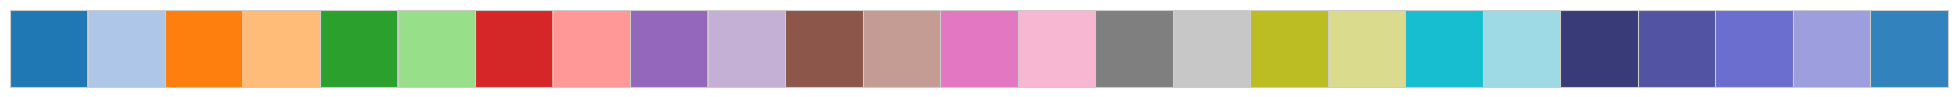

In [15]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
colors1 = cmap1.colors
colors2 = cmap2.colors
colors3 = cmap3.colors
contrast_palette = sns.color_palette(list(colors1) + list(colors2[:4]) + list(colors3[:1]))
sns.palplot(contrast_palette)

733303543.py (2): The palette list has more values (25) than needed (16), which may not be intended.


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

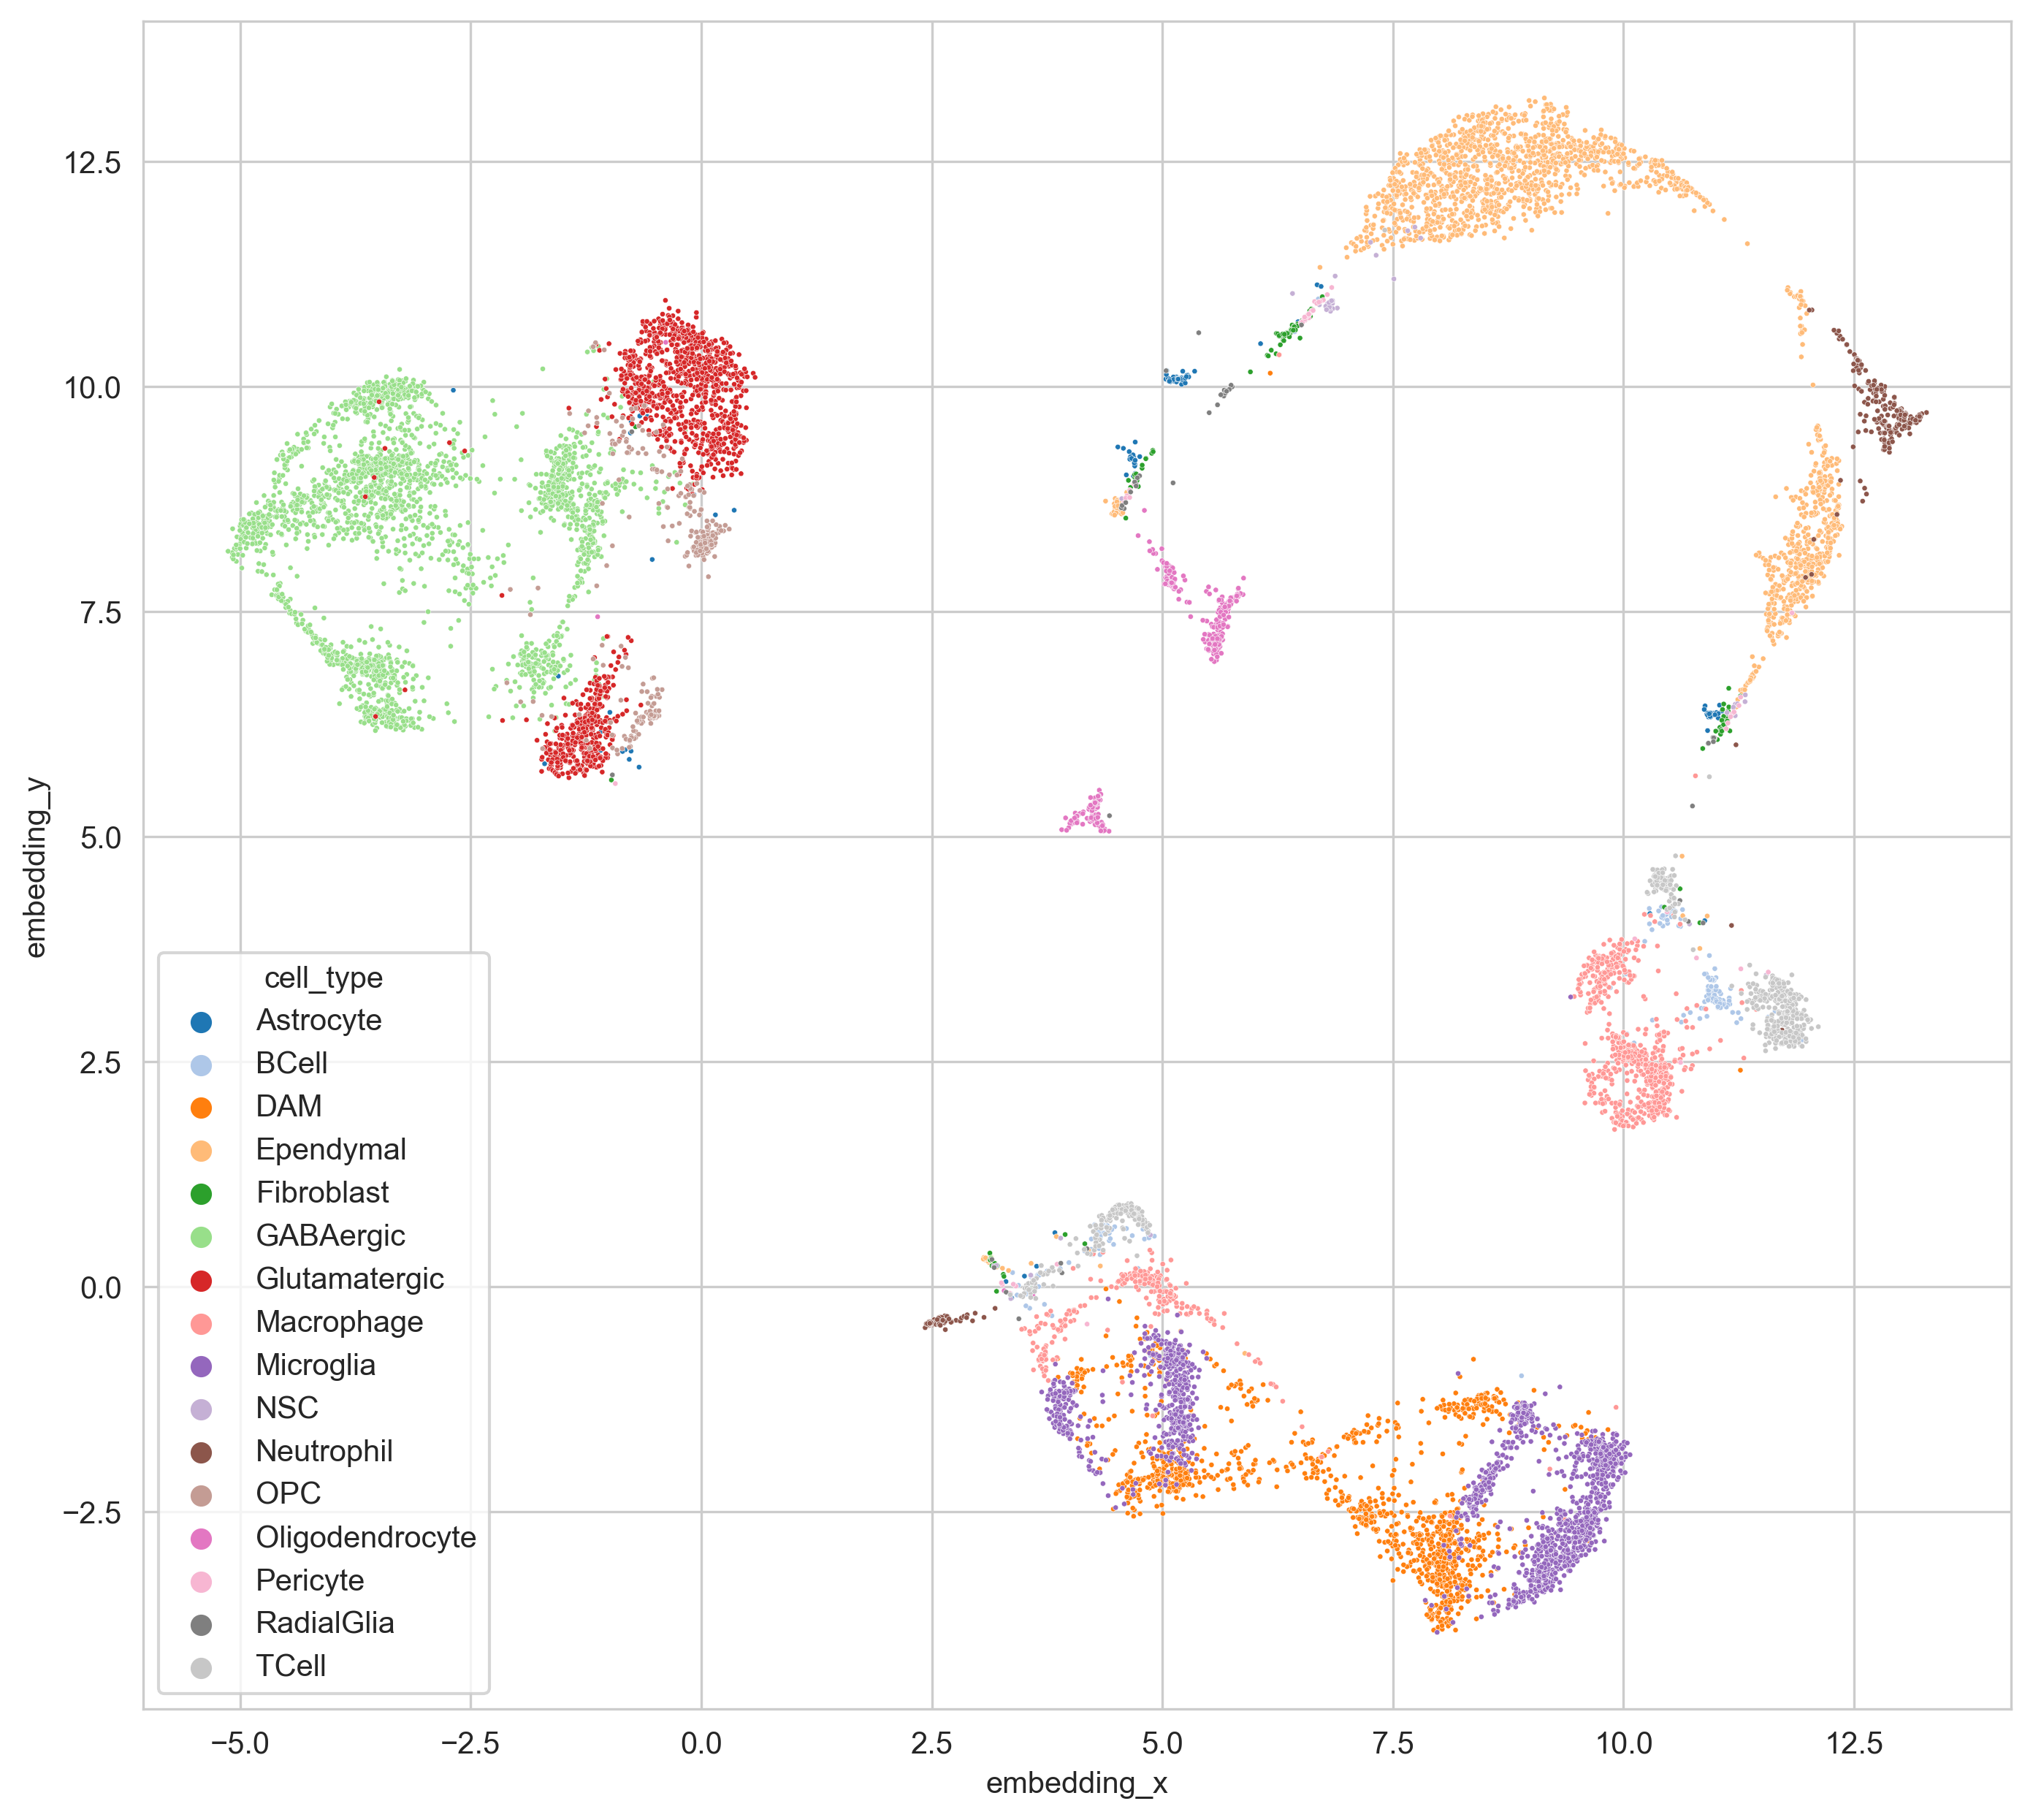

In [16]:
plt.figure(figsize=(11, 10), dpi=300)
sns.scatterplot(data = meta_df, x='embedding_x', y='embedding_y', s=3, hue='cell_type', palette=contrast_palette)
# plt.savefig(results_folder+'umap/umap1')

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.log(X[meta_df['cell_type']=='Microglia']+1))
meta_df_micro = meta_df[meta_df['cell_type']=='Microglia']
meta_df_micro.loc[:, 'embedding_x'] = embedding[:, 0]
meta_df_micro.log[:, 'embedding_y'] = embedding[:, 1]

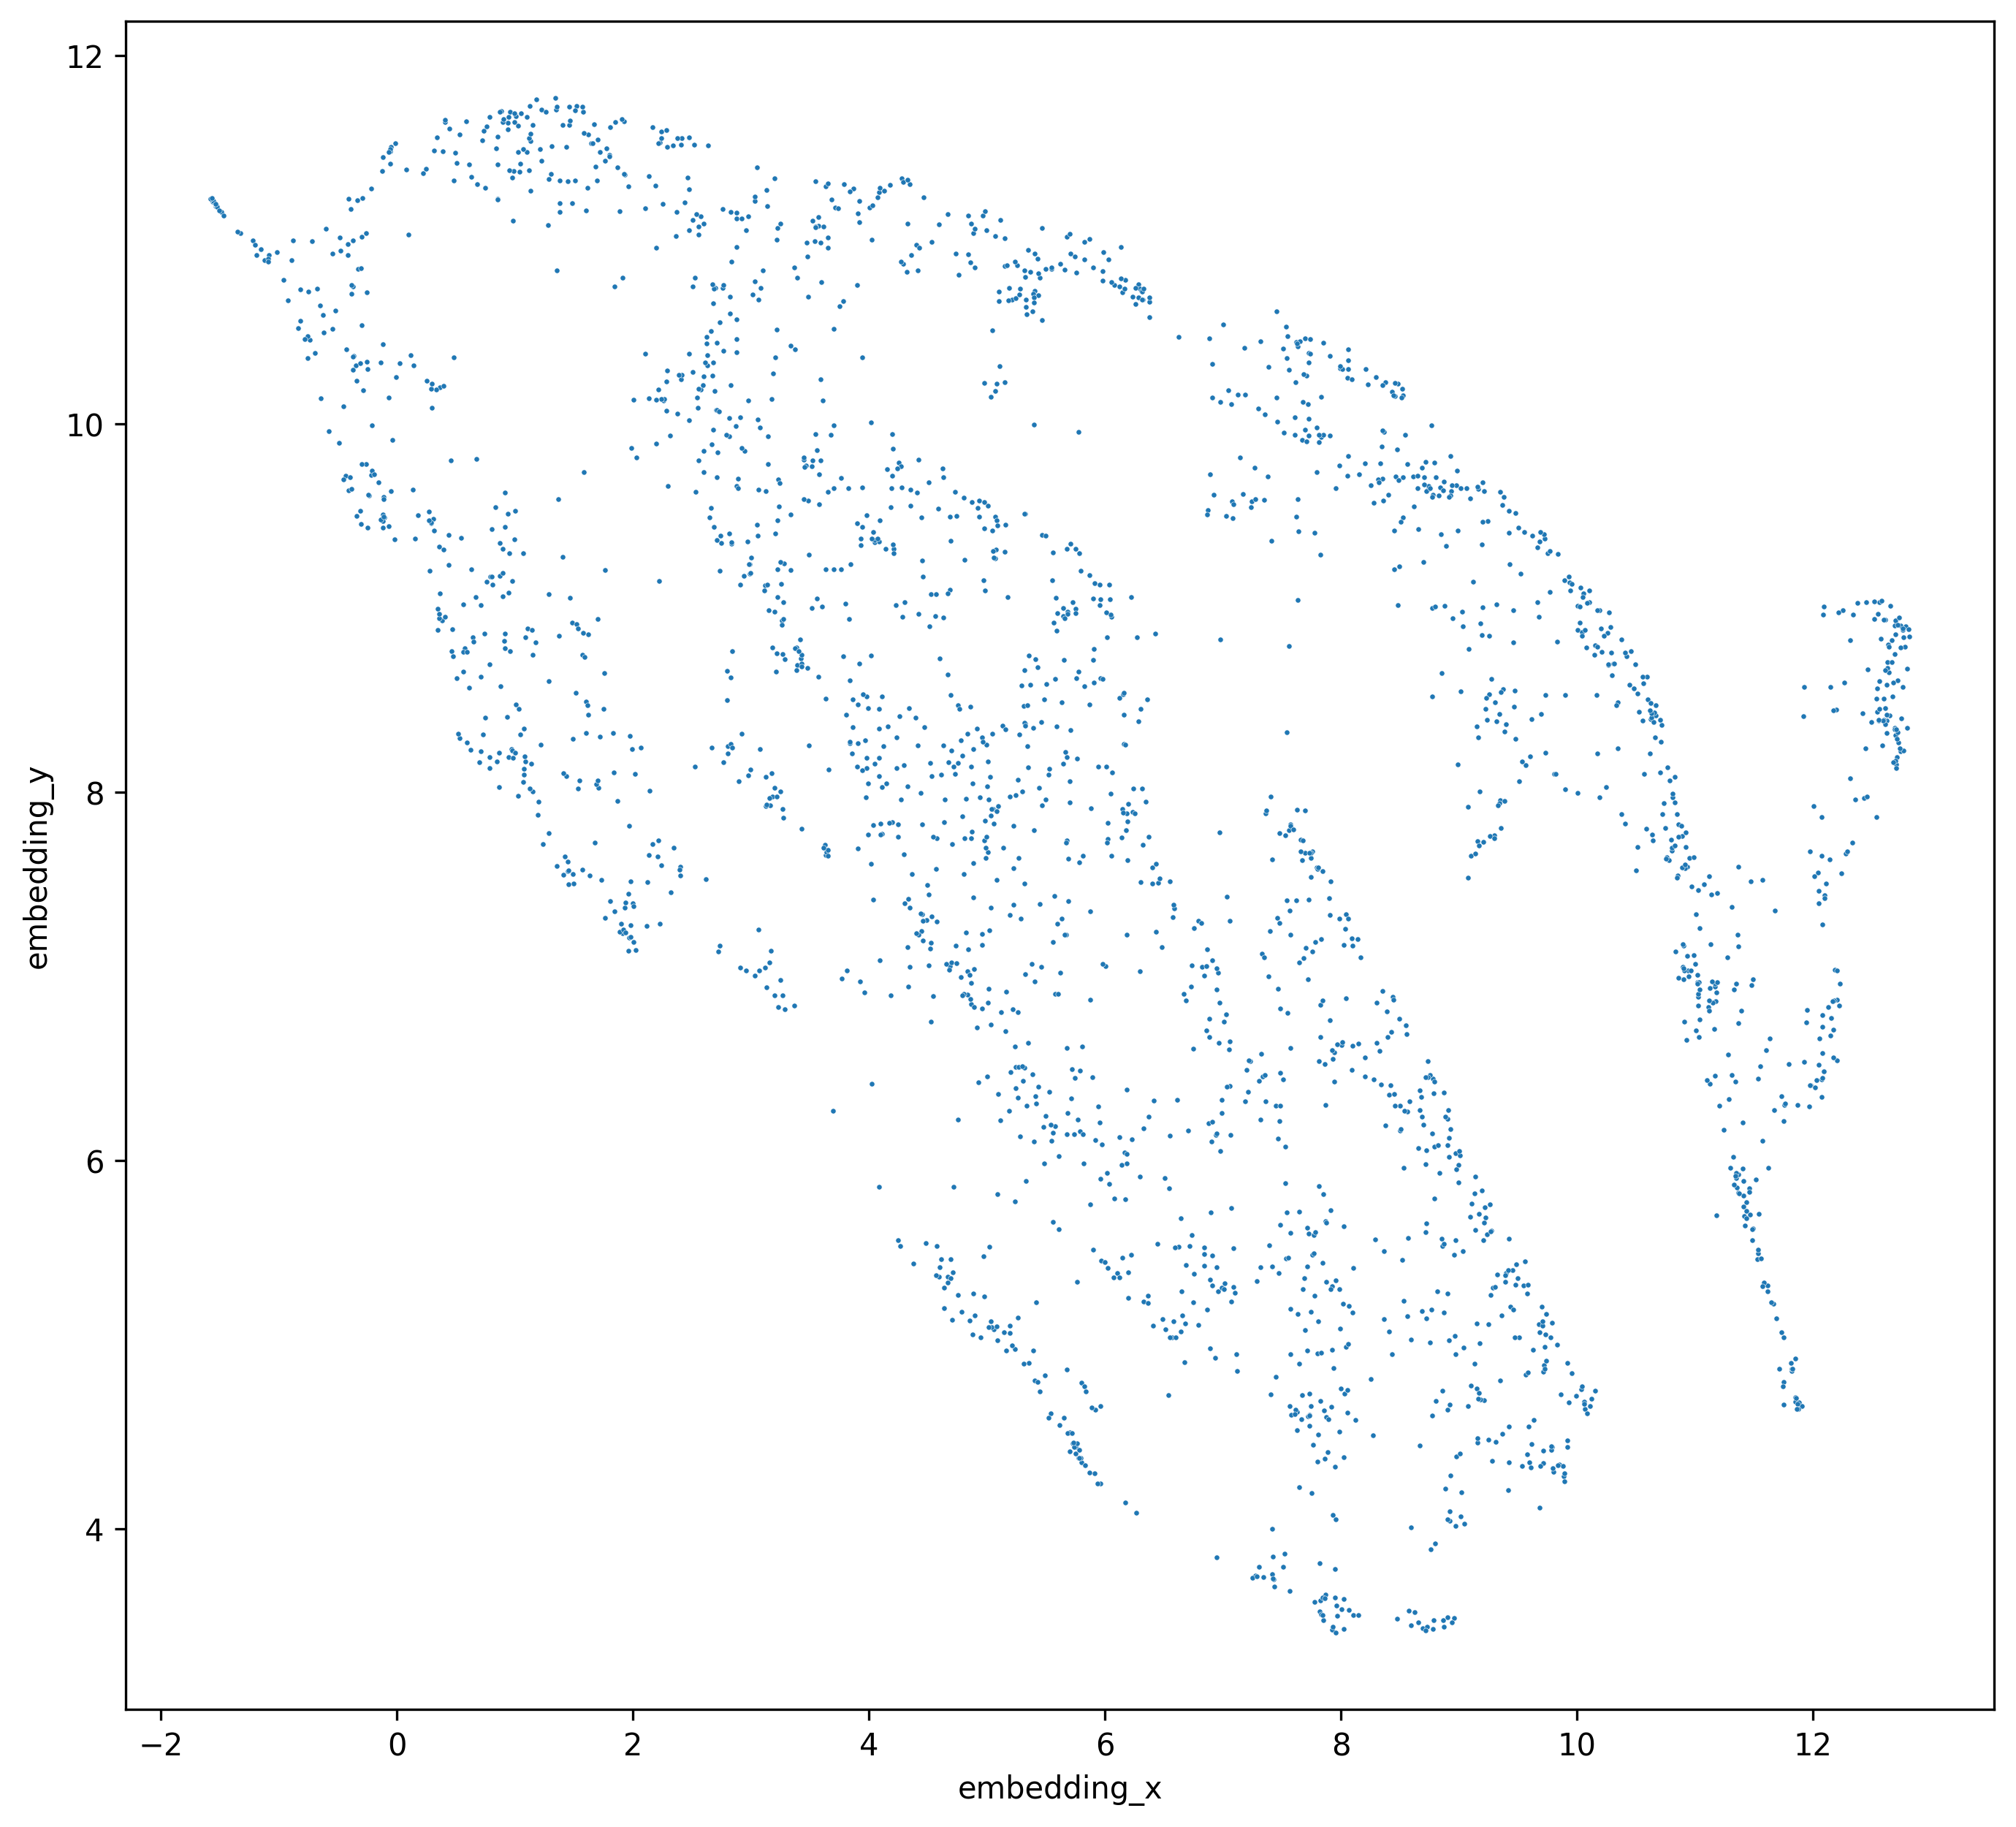

In [34]:
plt.figure(figsize=(11, 10), dpi=300)
sns.scatterplot(data = meta_df_micro, x='embedding_x', y='embedding_y', s=3)
plt.savefig(results_folder+'umap/umap_micro')

In [18]:
adata_st_decomposed_copy = adata_st_decomposed.copy()
sc.pp.normalize_per_cell(adata_st_decomposed_copy, counts_per_cell_after=1e4)
# sc.pp.log1p(adata_xe_copy)
adata_st_decomposed_copy.raw = adata_st_decomposed_copy
sc.pp.neighbors(adata_st_decomposed_copy, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata_st_decomposed_copy)

         Falling back to preprocessing with `sc.pp.pca` and default params.


scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


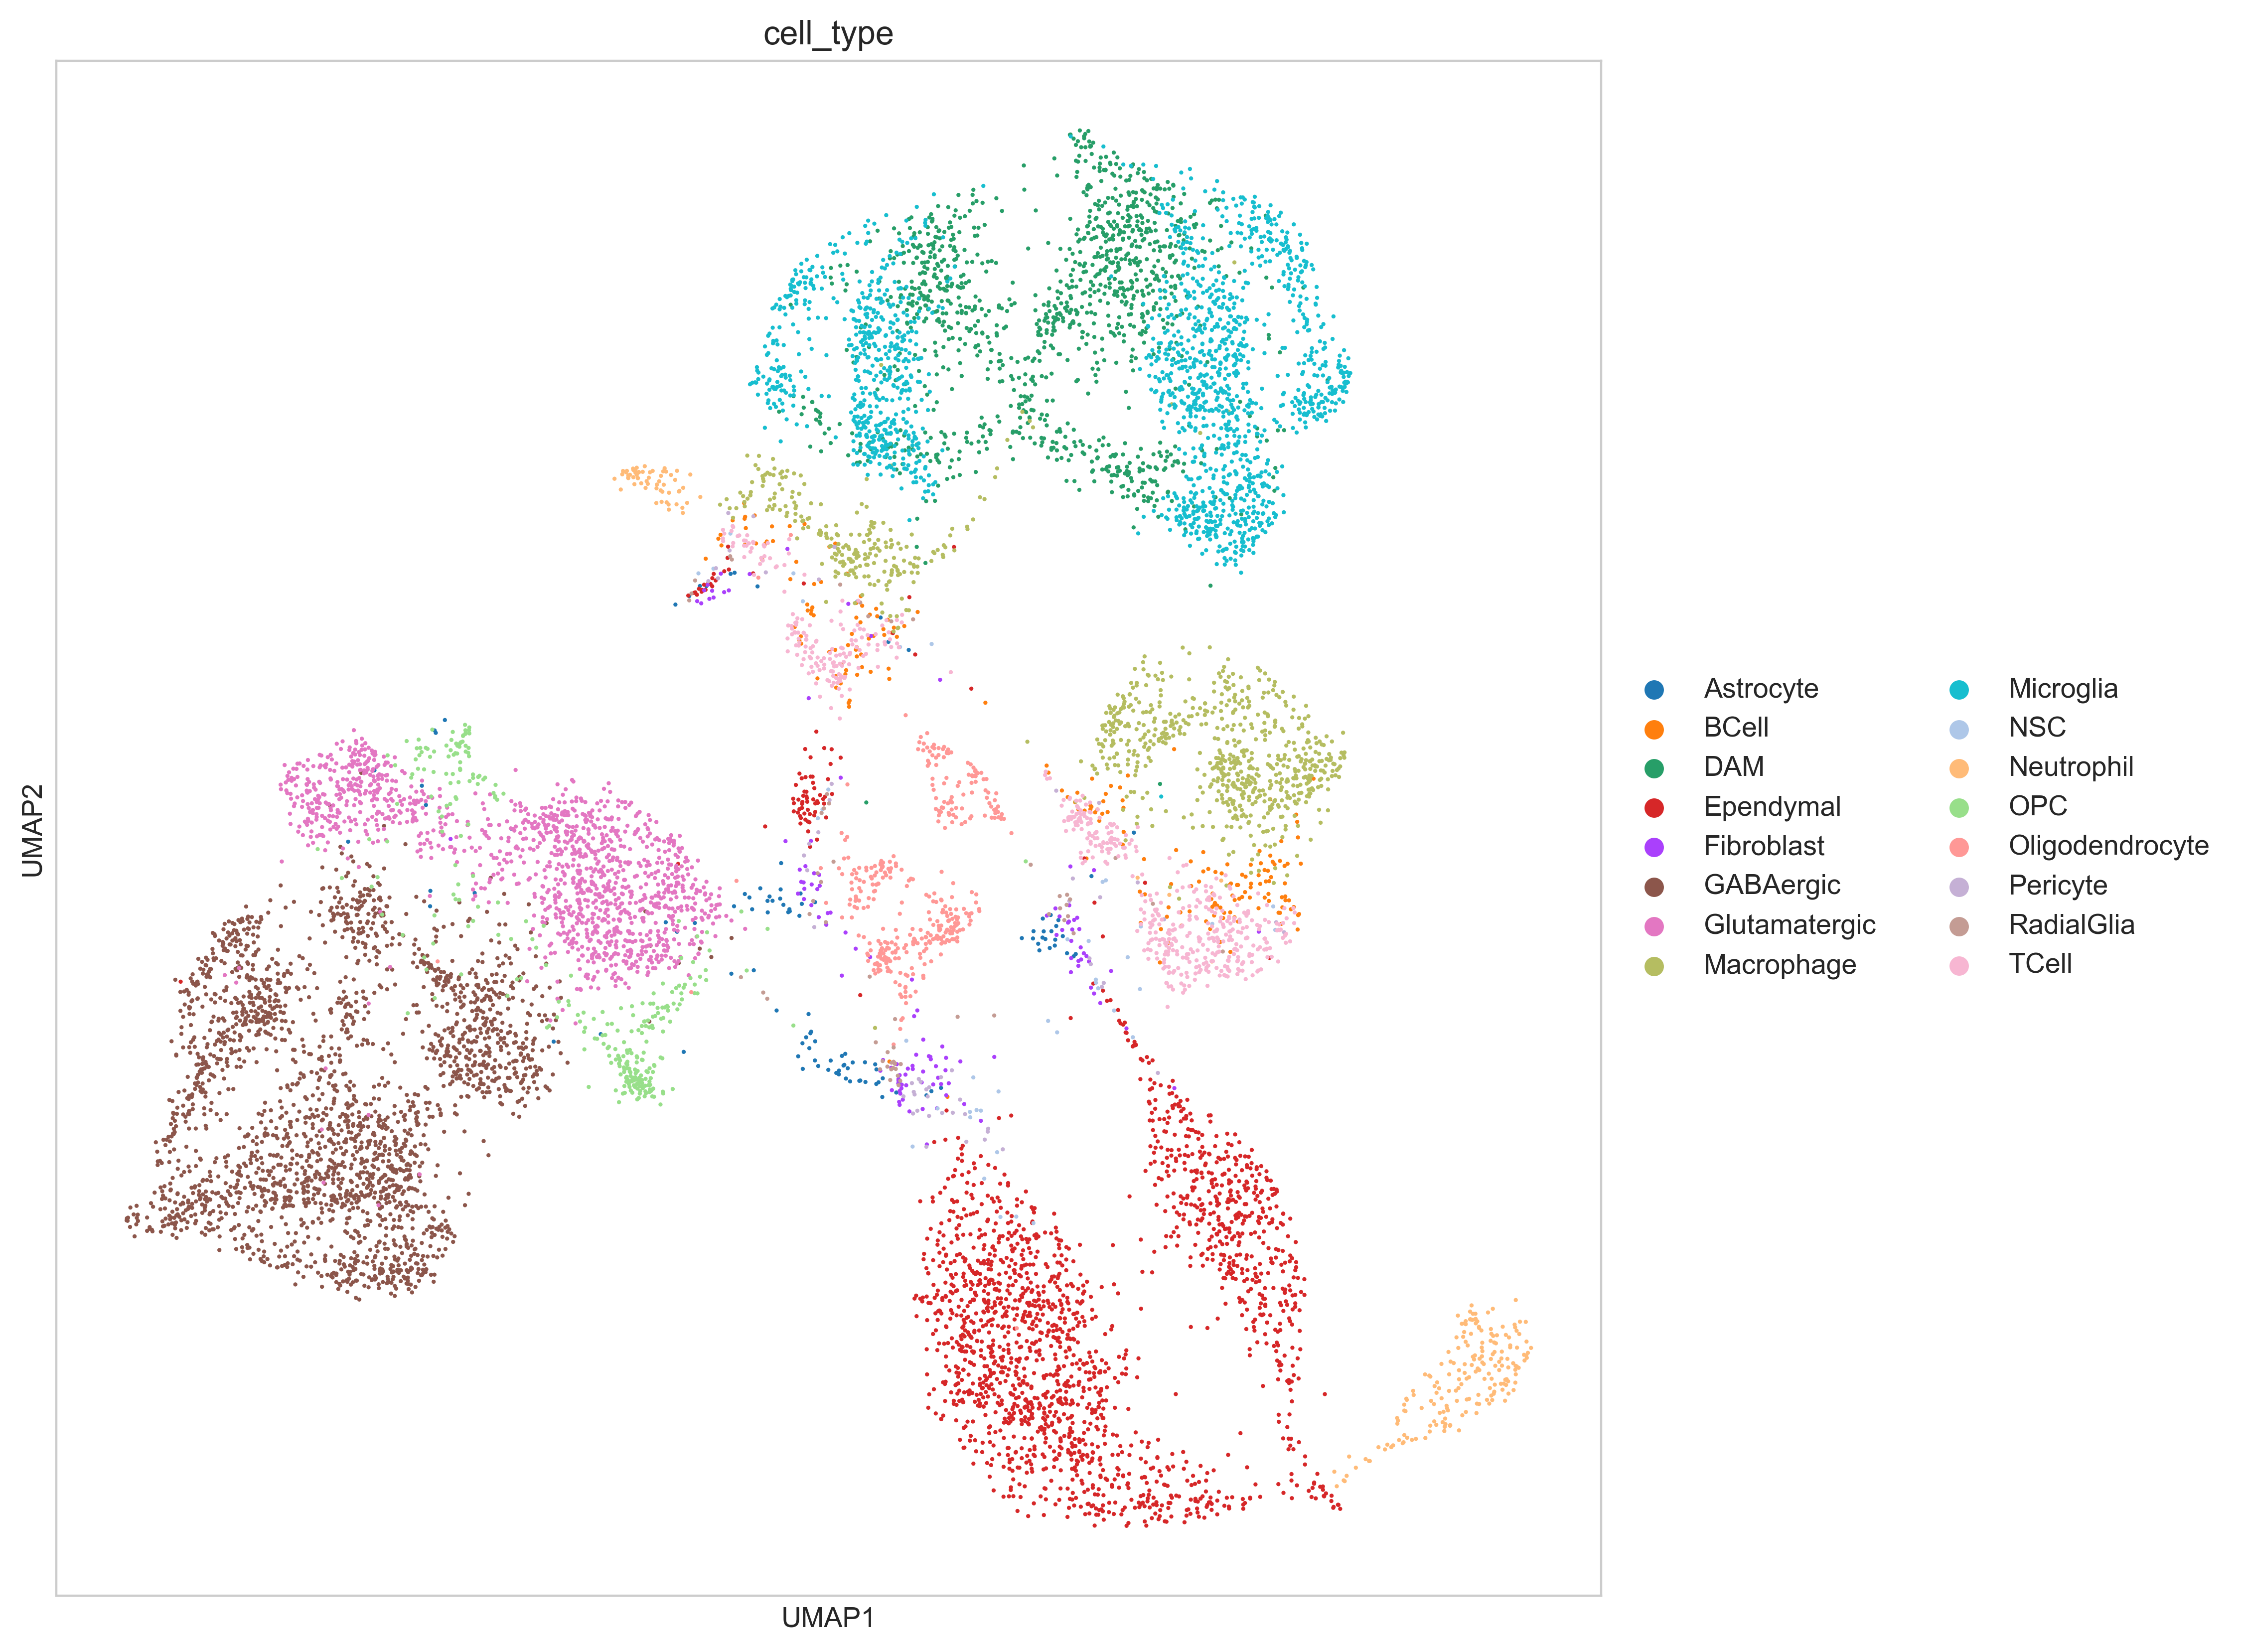

In [19]:
with mpl.rc_context({'figure.figsize': [10, 10], 'figure.dpi': 400}):
    ax = sc.pl.umap(adata_st_decomposed_copy, color='cell_type', size=9, show=False)
    ax.get_figure().savefig(results_folder+'umap/umap_scanpy_simu')

2301526107.py (8): Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


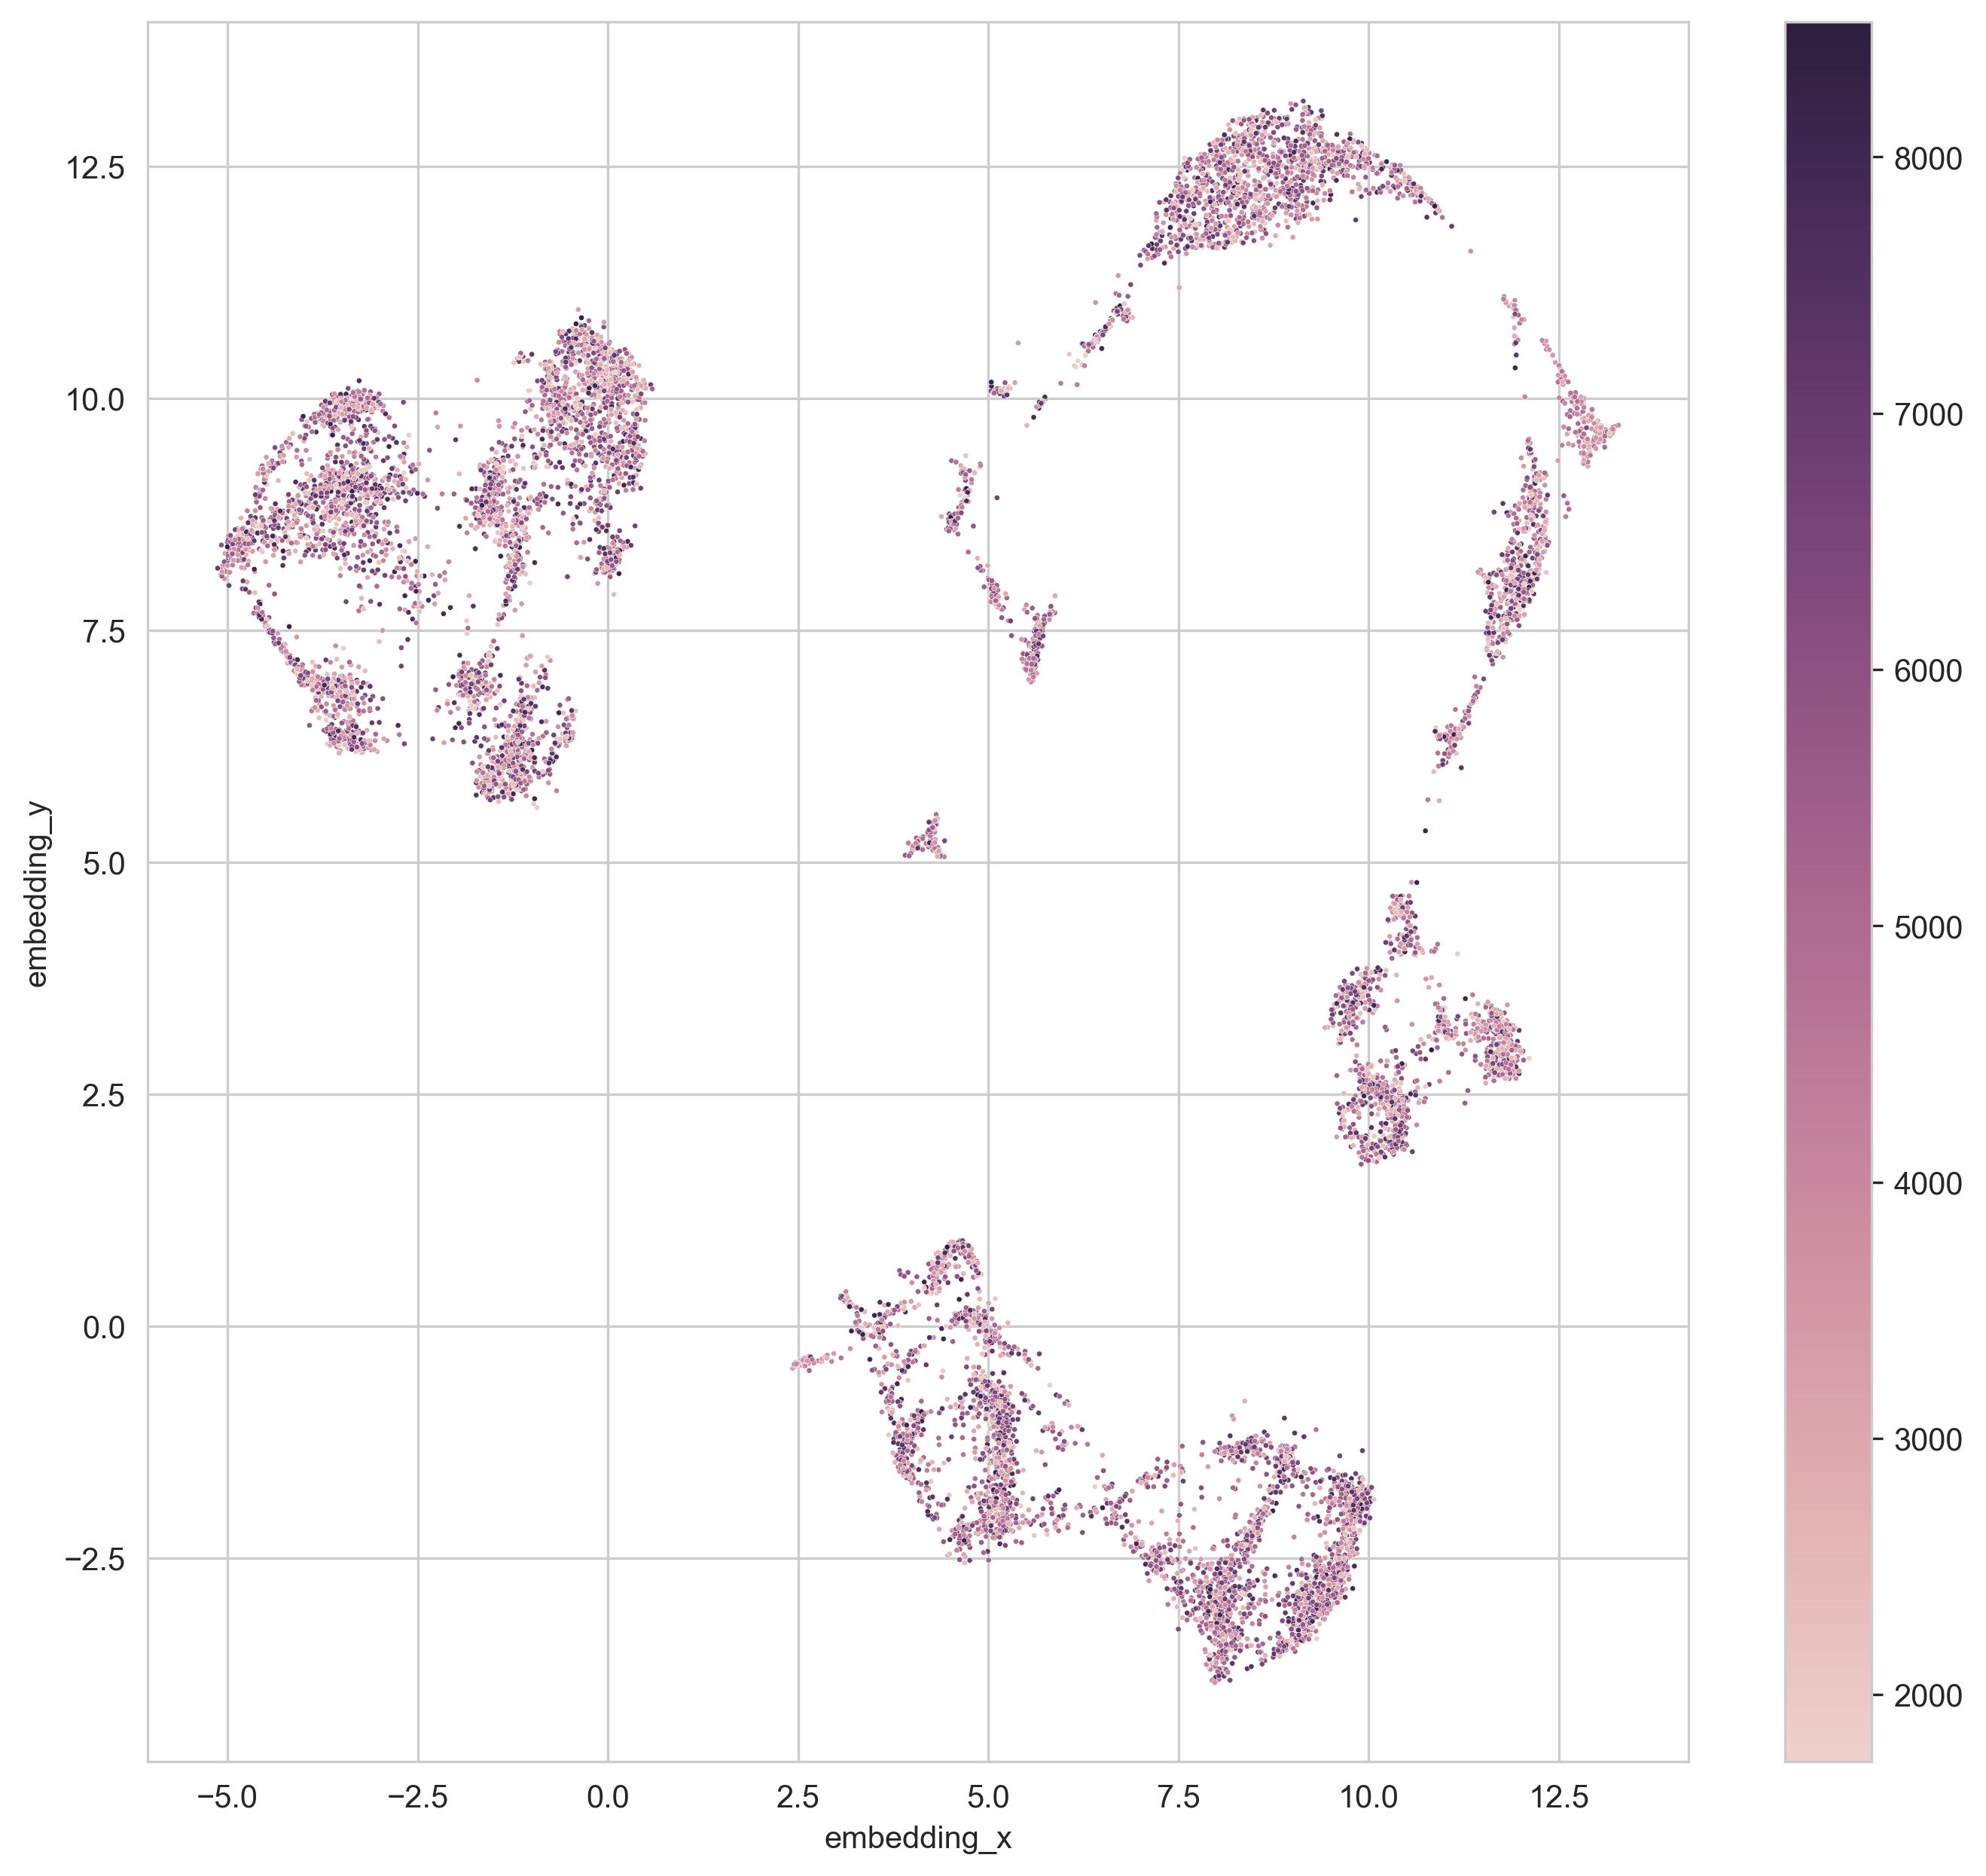

In [21]:
plt.figure(figsize=(11, 10), dpi=300)
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data = meta_df, x='embedding_x', y='embedding_y', s=3, hue='location_x', palette=cmap, legend=False)

norm = plt.Normalize(meta_df['location_x'].min(), meta_df['location_x'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm)
plt.savefig(results_folder+'umap/umap_x_simu')